## 4강 객체 검출과 머신 러닝

본 항목에서는 아래 항목들을 다룬다

+ GrabCut 알고리즘을 사용해 객체 마스크 얻기
+ Canny 알고리즘을 사용해 에지 찾기
+ Hough 변환을 사용한 직선과 원 검출
+ 템플릿 매칭을 통한 객체 찾기
+ 실시간 메디안 플로우 객체 추적기
+ 추적 API의 다양한 알고리즘을 사용한 객체 추적
+ 두 프레임 사이의 밀집 옵티컬 플로우 계산
+ 체스판과 원 그리드 패턴 검출
+ SVM 모델을 사용한 단순 보행자 검출기
+ 다양한 머신 러닝 모델을 사용한 광학 문자 인식

### GrabCut 알고리즘을 사용해 객체 마스크 얻기  
 가우시안 모델을 사용하여 반자동으로 객체 마스크를 생성할 수 있다.  
 처음 관심 영역을 선택 -> 오류를 직접 수정 -> 객체 검출   

cv2.grabCut(3 채널 이미지, 픽셀에 대한 초기 레이블이 있는 행렬, 레이블 초기값을 정의하는 (x, y, w, h) 형식의 사각형, 처리 상태를 저장할 두 개의 행렬, 반복 횟수, 실행할 함수에 대한 모드)  
  cv2.GC_INIT_WITH_RECT: 함수의 세 번째 인수인 사각형으로 초기 레이블을 정의할 때 사용한다. 이 경우 사각형의 외부 픽셀은 cv2.GV_BGD로 설정되고, 사각형 내부의 픽셀은 cv2.GC_PR_FGD 값으로 설정된다.  
  cv2.GC_INIT_WITH_MASK: 초기 레이블을 함수의 두 번째 인수인 행렬의 값을 사용한다. 이 경우 값을 cv2.GC_BG, cv2.GC_PR_BGD, cv2.GC_PR_FGD, cv2.GC_FGD 중 하나로 설정해야 한다.  
      -> 어떻게 사용하는지 모르겠음  
  cv2.GC_Ebal은 동일한 상태로 다른 반복횟수로 함수를 호출할 때 사용한다  

반환값: 레이블 행렬, 처리상태를 나타내는 행렬 2개.  
  cv2.GC_BGD(픽셀이 배경에 확실히 속함), cv2.GC_PR_BGD(픽셀이 배경에 속할 수 있음), cv2.GC_PR_FGD(픽셀이 전경에 속할 수 있음), cv2.GC_FGD(픽셀이 전경에 확실히 속함)  

In [2]:
from cv2 import cv2
import numpy as np
import matplotlib.pyplot as plt

In [31]:
img = cv2.imread('../data/minguri.jpg', cv2.IMREAD_COLOR)
show_img = np.copy(img)

mouse_pressed = False
y = x = w = h = 0

def mouse_Callback(event, _x, _y, flags, param):
    global show_img, x, y, w, h, mouse_pressed

    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        x, y = _x, _y
        show_img = np.copy(img)

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            show_img = np.copy(img)
            cv2.rectangle(show_img, (x, y), (_x, _y), (0, 255, 0), 3)
    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False
        w, h = _x - x, _y - y

cv2.namedWindow('image')
cv2.setMouseCallback('image', mouse_Callback)

while True:
    cv2.imshow('image', show_img)
    k = cv2.waitKey(1)

    if k == ord('a') and not mouse_pressed:
        if w*h > 0:
            break
cv2.destroyAllWindows()

labels = np.full(img.shape[:2], cv2.GC_INIT_WITH_MASK, np.uint8)
bgdModel = np.full(img.shape[:2], cv2.GC_PR_BGD, np.float64)
fgdModel = np.full(img.shape[:2], cv2.GC_PR_FGD, np.float64)

labels, bgdModel, fgdModel = cv2.grabCut(img, labels, (x, y, w, h), None, None, 1, cv2.GC_INIT_WITH_RECT)

show_img = np.copy(img)
show_img[(labels == cv2.GC_PR_BGD)|(labels == cv2.GC_BGD)] //= 3
cv2.imshow('image', show_img)
cv2.waitKey()
cv2.destroyAllWindows()

label = cv2.GC_BGD
lbl_clrs = {cv2.GC_BGD: (0,0,0), cv2.GC_FGD: (255,255,255)}

def mouse_callback(event, x, y, flags, param):
    global mouse_pressed

    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        cv2.circle(labels, (x, y), 5, label, -1)
        cv2.circle(show_img, (x, y), 5, lbl_clrs[label], -1)

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            cv2.circle(labels, (x,y), 5, label, -1)
            cv2.circle(show_img, (x, y), 5, lbl_clrs[label], -1)

    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False

cv2.namedWindow('image')
cv2.setMouseCallback('image', mouse_callback)

while True:
    cv2.imshow('image', show_img)
    k = cv2.waitKey(1)

    if k == ord('a') and not mouse_pressed:
        break
    
    elif k == ord('l'):
        label = cv2.GC_FGD - label

cv2.destroyAllWindows()

labels, bgdModel, fgdModel = cv2.grabCut(img, labels, None, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

show_img = np.copy(img)
show_img[(labels == cv2.GC_PR_BGD)|(labels == cv2.GC_BGD)] //= 3

cv2.imshow('image_last', show_img)
cv2.waitKey()
cv2.destroyAllWindows()

### Canny 알고리즘을 사용해 에지 찾기  

참고: https://m.blog.naver.com/samsjang/220507996391


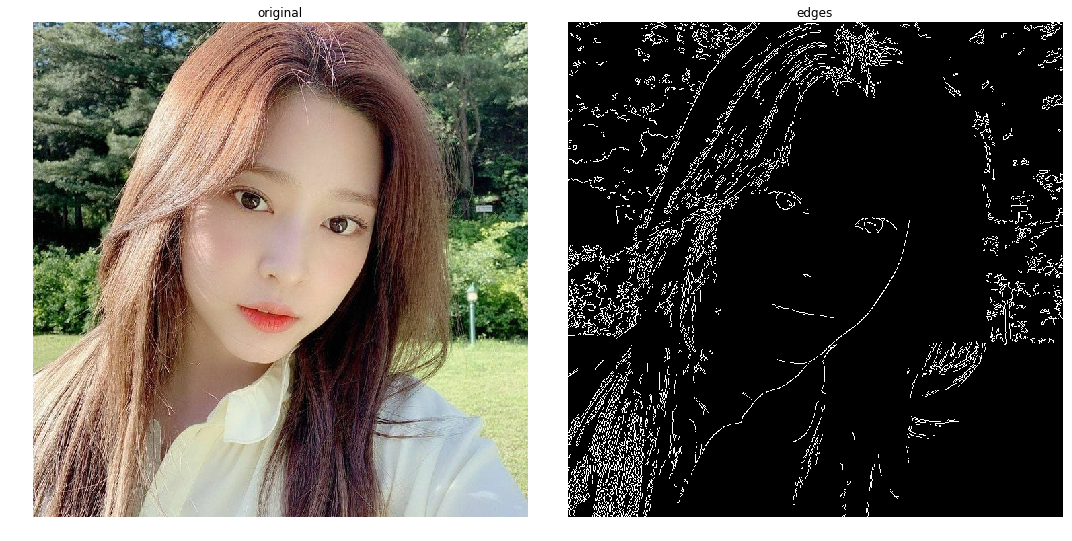

In [65]:
image = cv2.imread('../data/minguri.jpg')
edges = cv2.Canny(image, 200, 500)
#  The smallest value between threshold1 and threshold2 is used for edge linking.
# cv2.Canny(src, minValue, MaxValue)
#       minValue: 이것 보다 작은 값이면 에지 아님!
#       MaxValue: 이것 보다 크면 무조건 에지!
#       minValue < value < MaxValue: 연결된(linking) 정보를 바탕으로 판단

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.axis('off')
plt.title('original')
plt.imshow(image[:,:,[2,1,0]])
plt.subplot(122)
plt.axis('off')
plt.title('edges')
plt.imshow(edges, cmap='gray')
plt.tight_layout()
plt.show()

### Hough 변환을 사용해 직선과 원 검출  
  
이 방법은 기본 이미지 분석을 수행하고 이미지에서 프리미티브를 찾을 때 유용하다  
  (  ㅇ [그래픽]  그래픽 표현으로써의 `프리미티브`  
     - 그림을 만드는 기본 요소 즉, 그래픽(그림)에 대한 가장 기초가되는 표현(서술) 요소  
        . 그래픽 요소를 기술하는데 사용되는 그래픽 패키지 내의 관련 함수를 지칭하기도 함  
     - `점은 좌표 위치를 지정`하게되며, `선분은 두 좌표를 지정`하는 등)  

참고: https://m.blog.naver.com/samsjang/220588392347  

cv2.HoughLineP(입력 이미지, 직선의 거리에 대한 투표 공간(?), 직선의 각도에 대한 투표 공간, 최소 투표 임계값, 최소 직선 길이, 동일 직선상의 점들 사이 최대 간격)  
cv2.HoughCircles(입력 이미지, 검출방법, 해상도에 대한 투표 공간의 반비례 비율, 검출된 원 중심 사이의 최소거리, Canny 에지 검출과정에서 사용되는 상위 임계값, 투표수에 대한 임계값)

47.400001525878906
Detected circcle: center=(584.5 493.5), radius=45.599998474121094
Detected circcle: center=(133.5 134.5), radius=42.70000076293945
Detected circcle: center=(149.5 353.5), radius=42.70000076293945
Detected circcle: center=(61.5 361.5), radius=34.400001525878906
Detected circcle: center=(40.5 696.5), radius=32.20000076293945
Detected circcle: center=(58.5 626.5), radius=29.399999618530273
Detected circcle: center=(610.5 163.5), radius=29.200000762939453
Detected circcle: center=(585.5 578.5), radius=67.4000015258789
Detected circcle: center=(236.5 388.5), radius=58.400001525878906
Detected circcle: center=(398.5 119.5), radius=54.400001525878906
Detected circcle: center=(327.5 111.5), radius=48.599998474121094
Detected circcle: center=(304.5 104.5), radius=44.099998474121094
Detected circcle: center=(634.5 36.5), radius=34.400001525878906
Detected circcle: center=(562.5 48.5), radius=33.29999923706055
Detected circcle: center=(192.5 537.5), radius=31.5
Detected circcle

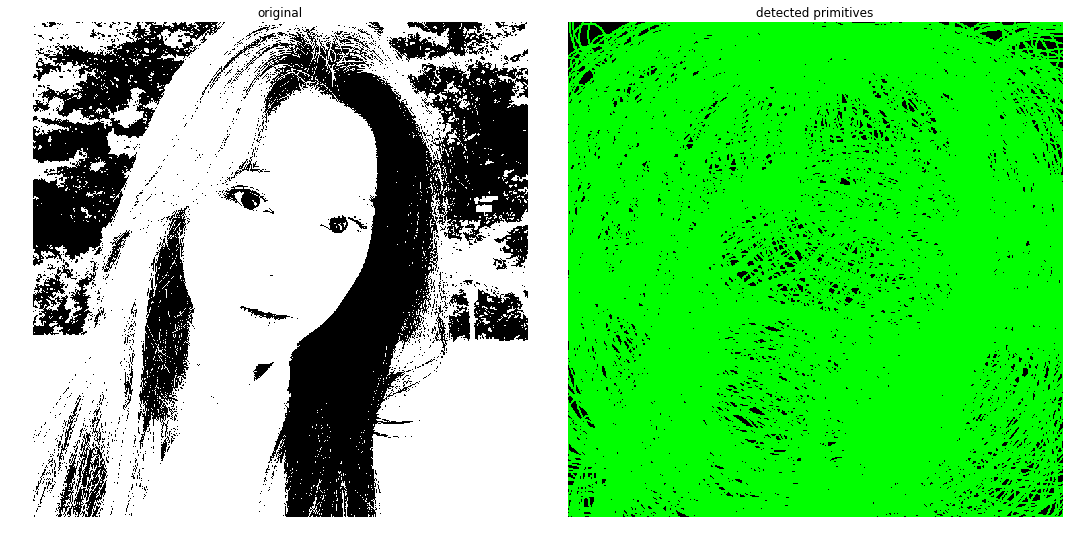

In [55]:
img = np.zeros((500,500), np.uint8)
cv2.circle(img, (200,200),50, 255, 3)
cv2.line(img, (100, 400), (400, 350), 255, 3)

# img = cv2.imread('../data/minguri.jpg', 0)
# thr, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
# 실제 이미지를 바로 사용하면 상당히 복잡한 사진이 나온다

lines = cv2.HoughLinesP(img, 1, np.pi/180, 100, 100, 10)[0] # 확률 허프변환 함수

circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 15, param1=200, param2=30)[0]

dbg_img = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)
for x1, y1, x2, y2 in lines:
    print('Detected line: ({} {}) ({} {})'.format(x1, y1, x2, y2))
    cv2.line(dbg_img, (x1, y1), (x2, y2), (0, 255,0), 2)

for c in circles:
    print('Detected circle: center=({} {}), radius={}'.format(c[0], c[1],c[2]))
    cv2.circle(dbg_img, (c[0], c[1]), c[2], (0, 255,0), 2)

plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.axis('off')
plt.title('original')
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.axis('off')
plt.title('detected primitives')
plt.imshow(dbg_img)
plt.tight_layout()
plt.show()

In [11]:
img = cv2.imread('../data/minguri.jpg')
show_img = np.copy(img)

mouse_pressed = False
y = x = w = h = 0

def mouse_callback(event, _x, _y, flags, param):
    global show_img, x, y, w, h, mouse_pressed

    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        x, y = _x, _y
        show_img = np.copy(img)

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            show_img = np.copy(img)
            cv2.rectangle(show_img, (x,y), (_x, _y), (0, 255, 0), 2)

    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False
        w, h = _x - x, _y - y

cv2.namedWindow('image')
cv2.setMouseCallback('image', mouse_callback)

while True:
    cv2.imshow('image', show_img)
    k = cv2.waitKey(1)

    if k == ord('a') and not mouse_pressed:
        if w*h > 0:
            break
cv2.destroyAllWindows()

template = np.copy(img[y:y+h, x:x+w])

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

show_img = np.copy(img)

while True:
    cv2.imshow('image', show_img)
    k = cv2.waitKey()

    if k == 27:
        break
    elif k > 0 and chr(k).isdigit():
        index = int(chr(k))
        if 0 <= index < len(methods):
    
            method = methods[index]
            res = cv2.matchTemplate(img, template, eval(method))
            res = cv2.normalize(res, None, 0, 1, cv2.NORM_MINMAX)

            if index >= methods.index('cv2.TM_SQDIFF'):
                loc = np.where(res < 0.01)
            else:
                loc = np.where(res > 0.99)

            show_img = np.copy(img)
            for pt in zip(*loc[::-1]):
                cv2.rectangle(show_img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
            res = cv2.resize(res, show_img.shape[:2])*255
            res = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR).astype(np.uint8)
            cv2.putText(res, method, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
            show_img = np.hstack((show_img, res))

cv2.destroyAllWindows()

#### 웹캠 버전

In [6]:
cap = cv2.VideoCapture(0)   # 0: default camera
#cap = cv2.VideoCapture("test.mp4") #동영상 파일에서 읽기

while cap.isOpened():
    # 카메라 프레임 읽기
    success, frame = cap.read()
    if success:
        # 프레임 출력
        cv2.imshow('Camera Window', frame)

        # ESC를 누르면 종료
        key = cv2.waitKey(1) & 0xFF
        if (key == 27): 
            img = np.copy(frame)
            break

cap.release()
cv2.destroyAllWindows()

show_img = np.copy(img)


mouse_pressed = False
y = x = w = h = 0

def mouse_callback(event, _x, _y, flags, param):
    global show_img, x, y, w, h, mouse_pressed

    if event == cv2.EVENT_LBUTTONDOWN:
        mouse_pressed = True
        x, y = _x, _y
        show_img = np.copy(img)

    elif event == cv2.EVENT_MOUSEMOVE:
        if mouse_pressed:
            show_img = np.copy(img)
            cv2.rectangle(show_img, (x,y), (_x, _y), (0, 255, 0), 2)

    elif event == cv2.EVENT_LBUTTONUP:
        mouse_pressed = False
        w, h = _x - x, _y - y

cv2.namedWindow('image')
cv2.setMouseCallback('image', mouse_callback)

while True:
    cv2.imshow('image', show_img)
    k = cv2.waitKey(1)

    if k == ord('a') and not mouse_pressed:
        if w*h > 0:
            break
cv2.destroyAllWindows()

template = np.copy(img[y:y+h, x:x+w])

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
# CCORR이 포함된 방법은 교차 상관 연산을 사용해 이미지 조각과 비교  -> 정확하나, 느리다
# SQKIFF가 포함도니 방법은 영역과 템플릿이 차이에 제곱한 값         -> 부정확하나, 빠르다

show_img = np.copy(img)


flag = False
cap = cv2.VideoCapture(0)
while cap.isOpened():
    # 카메라 프레임 읽기
    success, frame = cap.read()
    if success:
        # 프레임 출력
        cv2.imshow('Camera Window', frame)
        # ESC를 누르면 종료
        img = np.copy(frame)

        k = cv2.waitKey(1)
        if (k == 27): 
            img = np.copy(frame)
            break
        
        elif k > 0 and chr(k).isdigit() or flag == True:
            
            if flag == True and k-51 != index and k > 0:
                print('K', int(chr(k)))
                index = int(chr(k))
            
            if flag == False:
                index = int(chr(k))
                flag = True

            if 0 <= index < len(methods):

                method = methods[index]
                res = cv2.matchTemplate(img, template, eval(method))
                res = cv2.normalize(res, None, 0, 1, cv2.NORM_MINMAX)

                if index >= methods.index('cv2.TM_SQDIFF'):
                    loc = np.where(res < 0.01)
                else:
                    loc = np.where(res > 0.99)
                
                show_img = np.copy(img)
                for pt in zip(*loc[::-1]):
                    cv2.rectangle(show_img, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)

                res = cv2.resize(res, (show_img.shape[1], show_img.shape[0]))*255   # shape이 뒤집혀져 있다
                res = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR).astype(np.uint8)

                cv2.putText(res, method, (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)
                show_img = np.hstack((show_img, res))

        cv2.imshow('image', show_img)
cv2.destroyAllWindows()

K 2
K 3
K 1
K 1
K 2
K 3
K 4
K 5
K 6
K 1
K 2
K 2
K 3


### 메디안 플로우 객체 추적기  



In [33]:
cap = cv2.VideoCapture(0)
# cap = cv2.VideoCapture("../data/wonyong_video.mp4")
_, frame = cap.read()
bbox = cv2.selectROI(frame, False, True)

cv2.destroyAllWindows()
fps = 0

tracker = cv2.TrackerMedianFlow_create()
status_tracker = tracker.init(frame, bbox)


while True:
    status_cap, frame = cap.read()
    if not status_cap:
        break
    
    if status_tracker:
        timer = cv2.getTickCount()
        status_tracker, bbox = tracker.update(frame)
    
    if status_tracker:
        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 5)
        fps = cv2.getTickFrequency() / (cv2.getTickCount()-timer)
        cv2.putText(frame, "FPS: %.0f" % fps, (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 4)
    
    else:
        cv2.putText(frame, "Tracking faulure detected", (0, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 4)


    cv2.imshow("MedianFlow tracker", frame)

    k = cv2.waitKey(1)
    if k == 27:
        break

cv2.destroyAllWindows()

